# Load Packages

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
# LightGBM is a gradient boosting framework that uses tree based learning algorithms
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    true_positive_rate, false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Helper Functions

In [2]:
def split(sensitive_feature, str_sensitive_feature):
    # Train-test split
    df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(
    d.drop(columns=['race', 'action_taken', 'ethnicity', 'gender', 'age']), 
    Y, 
    sensitive_feature, 
    str_sensitive_feature,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)
    return df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test


def get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test):
    global unmitigated_model, test_scores, test_preds
    # unmitigated_model = test_scores = test_preds = None
    lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
    }
    model = lgb.LGBMClassifier(**lgb_params)
    model.fit(df_train, Y_train)
    print(model)
    unmitigated_model = model
    # Scores on test set
    test_scores = model.predict_proba(df_test)[:, 1]
    test_scores = test_scores
    print("Test Scores: ", test_scores)
    # Train AUC
    print( "AUC: ", roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1]))
    # Predictions (0 or 1) on test set
    test_preds = (test_scores >= np.mean(Y_train)) * 1
    # LightGBM feature importance 
    lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
    plt.show()
    # We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (false positives and false negatives) on the test data.
    mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=A_str_test)
    print(mf.by_group)
    # We calculate several performance and fairness metrics below:
    # Metrics
    models_dict = {"Unmitigated": (test_preds, test_scores)}
    print()
    print(get_metrics_df(models_dict, Y_test, A_str_test))
    
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        # defined by team6 - equal opportunity - the percentage of people that have rightfully benefitted from the loan model
        "True positive rate": (
            lambda x: true_positive_rate(y_true, x), True),
        # defined by team6 - equalized odds - the percentage of people that have wrongfully benefitted from the loan model
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        # defined by UCI Ex - 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.)
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def get_thresholdOptimizer_model(model, test_preds_, test_scores_, A_train, A_test, A_str_test):
    # global TO, postprocess_est, postprocess_preds, df_train_balanced, Y_train_balanced, A_train_balanced, test_scores, test_preds, models_dict
    global TO, postprocess_est, postprocess_preds, test_scores, test_preds, models_dict

    # TO = postprocess_est = postprocess_preds = df_train_balanced = Y_train_balanced = A_train_balanced= test_scores = test_preds = None

    test_scores_ = test_scores
    test_preds_ = test_preds
    postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)
    # Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
    # as there are points in the minority class (Y=1)
    balanced_idx1 = df_train[Y_train==1].index
    pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234, replace=True).index)
    df_train_balanced = df_train.loc[pp_train_idx, :]
    Y_train_balanced = Y_train.loc[pp_train_idx]
    A_train_balanced = A_train.loc[pp_train_idx]
    # save the parameters
    postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)
    TO = postprocess_est
    postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)
    
    postprocess_preds = postprocess_preds
    models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
    models_dict = models_dict
    print(get_metrics_df(models_dict, Y_test, A_str_test))
    return df_train_balanced, Y_train_balanced, A_train_balanced
    
def get_gridSearch_model(model, postprocess_preds, test_scores, test_preds, models_dict, A_str_test, df_train_balanced, Y_train_balanced, A_train_balanced):
    global GS_models, GS_metrics
    # GS_models = GS_metrics = None
    # Train GridSearch
    sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=1000,
                   grid_limit=10)

    sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)
    sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
    sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]
    equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
    ]
    balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
    auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]
    # Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
    all_results = pd.DataFrame(
        {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
    ) 
    non_dominated = []
    models = []
    for row in all_results.itertuples(): 
        accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
        if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
            models.append(row)
            non_dominated.append(True)
        else:
            non_dominated.append(False)
    GS_models = models
    equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
    balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
    auc_non_dominated = np.asarray(auc_sweep)[non_dominated]
    # Plot equalized odds difference vs balanced accuracy
    plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
    plt.scatter(balanced_accuracy_score(Y_test, test_preds),
                equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
                label="Unmitigated Model")
    plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
                equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
                label="ThresholdOptimizer Model")
    plt.xlabel("Balanced Accuracy")
    plt.ylabel("Equalized Odds Difference")
    plt.legend(bbox_to_anchor=(1.55, 1))
    plt.show()
    # As intended, GridSearch models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.
    # Plot equalized odds difference vs AUC
    plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
    plt.scatter(roc_auc_score(Y_test, test_scores),
                equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
                label="Unmitigated Model")
    plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
                equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
                label="ThresholdOptimizer Model")
    plt.xlabel("AUC")
    plt.ylabel("Equalized Odds Difference")
    plt.legend(bbox_to_anchor=(1.55, 1))
    plt.show()
    # Similarly, GridSearch models appear along the trade-off curve between AUC and equalized odds difference.
    # Compare GridSearch models with low values of equalized odds difference with the previously constructed models
    grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                        for i in range(len(sweep_preds))
                        if non_dominated[i] and equalized_odds_sweep[i]<0.1}
    models_dict.update(grid_search_dict)
    GS_metrics = models_dict
    print(get_metrics_df(models_dict, Y_test, A_str_test))


# Race - FL

In [3]:
# load the clean data
d = 'data/Fairlearn_FL_PortSL.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,1,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,1,1,2,2,4,2,2,3
2,0,1,0,1,0,1,1,2,2,4,2,3,1
3,0,1,0,1,0,1,3,2,2,2,2,3,1
4,0,1,0,1,0,1,1,2,2,2,3,2,1


In [4]:
# Extract the sensitive feature - example: race
A = d["race"].apply(lambda x:1 if x == 1 else 0)
A_str = A.map({ 1:"White", 0:"Non-White"})
A_str

0            White
1            White
2            White
3            White
4            White
           ...    
10601    Non-White
10602        White
10603        White
10604        White
10605        White
Name: race, Length: 10606, dtype: object

In [5]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10606 entries, 0 to 10605
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ethnicity              10606 non-null  int64   
 1   race                   10606 non-null  int64   
 2   gender                 10606 non-null  int64   
 3   action_taken           10606 non-null  int64   
 4   preapproval_requested  10606 non-null  category
 5   loan_type              10606 non-null  category
 6   loan_purpose           10606 non-null  category
 7   interest_only_payment  10606 non-null  category
 8   balloon_payment        10606 non-null  category
 9   debt_to_income_ratio   10606 non-null  category
 10  age                    10606 non-null  int64   
 11  income                 10606 non-null  category
 12  loan_to_value_ratio    10606 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 570.9 KB


In [6]:
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = split(A, A_str)

In [7]:
len(df_test)

3182

In [8]:
len(Y_test)

3182

In [9]:
A_str_test

785         White
7799        White
8429        White
1795        White
6528        White
          ...    
9352        White
8500    Non-White
8886    Non-White
7975        White
6830    Non-White
Name: race, Length: 3182, dtype: object

## Using a Fairness Unaware Model

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')
Test Scores:  [0.73134307 0.58012153 0.76348458 ... 0.61652904 0.90589617 0.77727798]
AUC:  0.8299348603498176


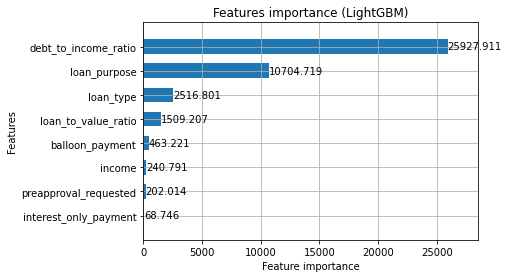

                FPR       FNR
race                         
Non-White  0.333333  0.102632
White      0.296736  0.158574

                               Unmitigated
Overall selection rate            0.702074
Demographic parity difference     0.007276
Demographic parity ratio          0.989724
------                                    
Overall balanced error rate       0.772877
Balanced error rate difference    0.009673
 ------                                   
True positive rate                0.850604
False positive rate difference    0.036597
False negative rate difference    0.055943
Equalized odds difference         0.055943
  ------                                  
Overall AUC                       0.833503
AUC difference                    0.004035


In [10]:
get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test)

In [11]:
unmitigated_FL_race = unmitigated_model
print(unmitigated_FL_race)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')


In [12]:
fl_race_test_scores = unmitigated_FL_race.predict_proba(df_test)[:, 1]

In [13]:
fl_race_test_preds = (fl_race_test_scores >= np.mean(Y_train)) * 1

In [14]:
fl_race_test_preds = pd.DataFrame(fl_race_test_preds)

In [15]:
A_str_test.reset_index(drop= True, inplace= True)

In [16]:
unmigigated_pred_mid_race = pd.concat([fl_race_test_preds , A_str_test], axis="columns")
unmigigated_pred_mid_race

,0,race
0,1,White
1,0,White
2,1,White
3,0,White
4,1,White
...,...,...
3177,1,White
3178,1,Non-White
3179,0,Non-White
3180,1,White


In [17]:
unmigigated_pred_mid_race.to_excel(r'fl_unmitigated_pred_race.xlsx', index=False)

## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [18]:
df_train_balanced_race_FL, Y_train_balanced_race_FL, A_train_balanced_race_FL = get_thresholdOptimizer_model(unmitigated_FL_race, test_preds, test_scores, A_train, A_test, A_str_test)

                               Unmitigated ThresholdOptimizer
Overall selection rate            0.702074           0.857637
Demographic parity difference     0.007276           0.020394
Demographic parity ratio          0.989724           0.976322
------                                                       
Overall balanced error rate       0.772877           0.718711
Balanced error rate difference    0.009673           0.002759
 ------                                                      
True positive rate                0.850604           0.976684
False positive rate difference    0.036597           0.009783
False negative rate difference    0.055943             0.0153
Equalized odds difference         0.055943             0.0153
  ------                                                     
Overall AUC                       0.833503           0.718711
AUC difference                    0.004035           0.002759


In [19]:
ThresholdOptimizer_FL_race = TO
print(ThresholdOptimizer_FL_race)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'),
                   prefit=True)


The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


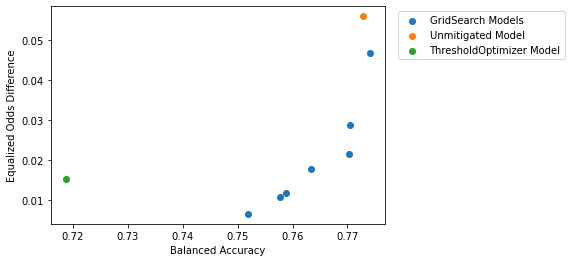

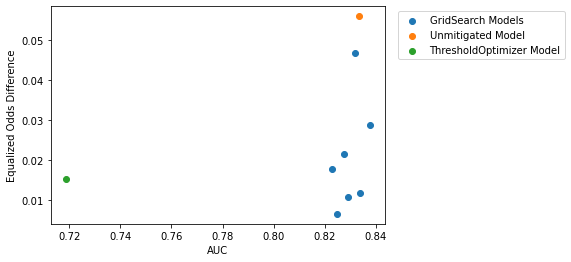

                               Unmitigated ThresholdOptimizer GridSearch_377  \
Overall selection rate            0.702074           0.857637       0.710245   
Demographic parity difference     0.007276           0.020394       0.030394   
Demographic parity ratio          0.989724           0.976322       0.957533   
------                                                                         
Overall balanced error rate       0.772877           0.718711       0.763419   
Balanced error rate difference    0.009673           0.002759       0.011337   
 ------                                                                        
True positive rate                0.850604           0.976684       0.853627   
False positive rate difference    0.036597           0.009783       0.004977   
False negative rate difference    0.055943             0.0153       0.017698   
Equalized odds difference         0.055943             0.0153       0.017698   
  ------                                

In [20]:
get_gridSearch_model(unmitigated_FL_race, postprocess_preds, test_scores, test_preds, models_dict, A_str_test, df_train_balanced_race_FL, Y_train_balanced_race_FL, A_train_balanced_race_FL)

In [21]:
GS_race_FL_models = GS_models
print(GS_race_FL_models)
print()
GS_race_FL_metrics = GS_metrics
print(GS_race_FL_metrics)

[Pandas(Index=377, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7634185523339995, disparity=0.017697912135711258), Pandas(Index=378, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.770241257723159, disparity=0.021389734667246585), Pandas(Index=379, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7741272680858533, disparity=0.04672140060896046), Pandas(Index=457, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7518462787237692, disparity=0.006481078729882461), Pandas(Index=460, predictor=LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary'), accuracy=0.7703868459995133, disparity=0.0287190

In [69]:
# chose the model with AUC = 85.98% from grid search
test_pred_gird_search_502 = GS_race_FL_metrics.get("GridSearch_502")[0]

In [70]:
test_pred_gird_search_502_series = pd.Series(test_pred_gird_search_502)
test_pred_gird_search_502_series.reset_index(drop=True, inplace=True)

In [71]:
A_str_test.reset_index(drop= True, inplace= True)

In [72]:
test_preds

array([1, 0, 1, ..., 0, 1, 1])

In [73]:
migigated_pred_mid_race = pd.concat([test_pred_gird_search_502_series , A_str_test], axis="columns")

In [74]:
migigated_pred_mid_race

,0,race
0,1,White
1,0,White
2,1,White
3,0,White
4,0,White
...,...,...
3177,1,White
3178,1,Non-White
3179,0,Non-White
3180,1,White


In [75]:
migigated_pred_mid_race.to_excel(r'fl_mitigated_pred_race.xlsx', index=False)

## Conclusion

In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.

# Age - FL

In [30]:
# load the clean data
d = 'data/Fairlearn_FL_PortSL.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,1,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,1,1,2,2,4,2,2,3
2,0,1,0,1,0,1,1,2,2,4,2,3,1
3,0,1,0,1,0,1,3,2,2,2,2,3,1
4,0,1,0,1,0,1,1,2,2,2,3,2,1


In [31]:
# Extract the sensitive feature - example: age - middle-aged vs non m-a
B = d["age"].apply(lambda x:1 if x == 2 else 0)
B_str = B.map({ 1:"Middle-Aged", 0:"Non-Middle-Aged"})
B_str

0        Non-Middle-Aged
1            Middle-Aged
2            Middle-Aged
3            Middle-Aged
4        Non-Middle-Aged
              ...       
10601        Middle-Aged
10602        Middle-Aged
10603        Middle-Aged
10604        Middle-Aged
10605    Non-Middle-Aged
Name: age, Length: 10606, dtype: object

In [32]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10606 entries, 0 to 10605
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ethnicity              10606 non-null  int64   
 1   race                   10606 non-null  int64   
 2   gender                 10606 non-null  int64   
 3   action_taken           10606 non-null  int64   
 4   preapproval_requested  10606 non-null  category
 5   loan_type              10606 non-null  category
 6   loan_purpose           10606 non-null  category
 7   interest_only_payment  10606 non-null  category
 8   balloon_payment        10606 non-null  category
 9   debt_to_income_ratio   10606 non-null  category
 10  age                    10606 non-null  int64   
 11  income                 10606 non-null  category
 12  loan_to_value_ratio    10606 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 570.9 KB


In [33]:
df_train, df_test, Y_train, Y_test, B_train, B_test, B_str_train, B_str_test = split(B, B_str)

## Using a Fairness Unaware Model

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')
Test Scores:  [0.73134307 0.58012153 0.76348458 ... 0.61652904 0.90589617 0.77727798]
AUC:  0.8299348603498176


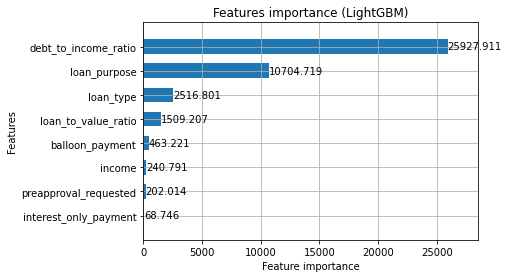

                      FPR       FNR
age                                
Middle-Aged       0.34188  0.131334
Non-Middle-Aged  0.279612  0.162342

                               Unmitigated
Overall selection rate            0.702074
Demographic parity difference       0.0449
Demographic parity ratio          0.938356
------                                    
Overall balanced error rate       0.772877
Balanced error rate difference     0.01563
 ------                                   
True positive rate                0.850604
False positive rate difference    0.062269
False negative rate difference    0.031008
Equalized odds difference         0.062269
  ------                                  
Overall AUC                       0.833503
AUC difference                     0.01788


In [34]:
get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, B_train, B_test, B_str_train, B_str_test)

In [35]:
unmitigated_FL_age = unmitigated_model
print(unmitigated_FL_age)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')


In [36]:
fl_age_test_scores = unmitigated_FL_age.predict_proba(df_test)[:, 1]
fl_age_test_preds = (fl_age_test_scores >= np.mean(Y_train)) * 1
fl_age_test_preds = pd.DataFrame(fl_age_test_preds)
B_str_test.reset_index(drop= True, inplace= True)
unmigigated_pred_mid_age = pd.concat([fl_age_test_preds , B_str_test], axis="columns")
unmigigated_pred_mid_age

,0,age
0,1,Non-Middle-Aged
1,0,Non-Middle-Aged
2,1,Non-Middle-Aged
3,0,Middle-Aged
4,1,Middle-Aged
...,...,...
3177,1,Middle-Aged
3178,1,Non-Middle-Aged
3179,0,Non-Middle-Aged
3180,1,Non-Middle-Aged


In [37]:
unmigigated_pred_mid_race.to_excel(r'fl_unmitigated_pred_age.xlsx', index=False)

## Mitigating Equalized Odds Difference with Postprocessing
We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [38]:
#get_thresholdOptimizer_model(unmitigated_FL_age, test_preds, test_scores, B_train, B_test, B_str_test)
df_train_balanced_age_FL, Y_train_balanced_age_FL, A_train_balanced_age_FL = get_thresholdOptimizer_model(unmitigated_FL_age, test_preds, test_scores, B_train, B_test, B_str_test)

print()
ThresholdOptimizer_FL_age = TO
print(ThresholdOptimizer_FL_age)

                               Unmitigated ThresholdOptimizer
Overall selection rate            0.702074           0.859522
Demographic parity difference       0.0449            0.00667
Demographic parity ratio          0.938356           0.992275
------                                                       
Overall balanced error rate       0.772877           0.710488
Balanced error rate difference     0.01563           0.002167
 ------                                                      
True positive rate                0.850604           0.974093
False positive rate difference    0.062269           0.000692
False negative rate difference    0.031008           0.003643
Equalized odds difference         0.062269           0.003643
  ------                                                     
Overall AUC                       0.833503           0.710488
AUC difference                     0.01788           0.002167

ThresholdOptimizer(constraints='equalized_odds',
                   e

The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


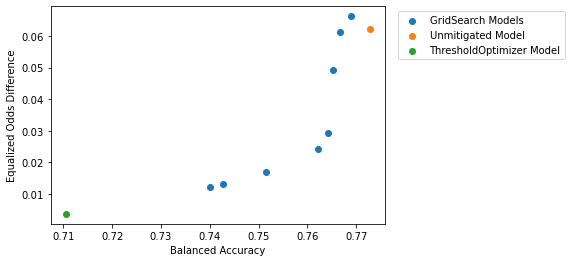

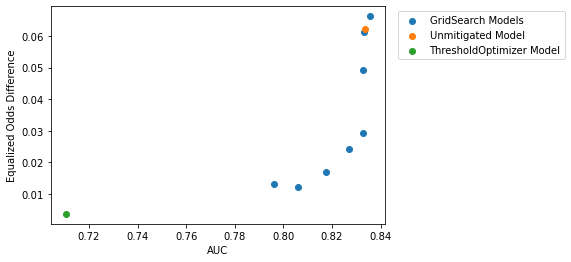

                               Unmitigated ThresholdOptimizer GridSearch_505  \
Overall selection rate            0.702074           0.859522       0.688246   
Demographic parity difference       0.0449            0.00667        0.06721   
Demographic parity ratio          0.938356           0.992275        0.90763   
------                                                                         
Overall balanced error rate       0.772877           0.710488       0.768931   
Balanced error rate difference     0.01563           0.002167       0.003034   
 ------                                                                        
True positive rate                0.850604           0.974093       0.834629   
False positive rate difference    0.062269           0.000692       0.066279   
False negative rate difference    0.031008           0.003643       0.060212   
Equalized odds difference         0.062269           0.003643       0.066279   
  ------                                

In [40]:
get_gridSearch_model(unmitigated_FL_age, postprocess_preds, test_scores, test_preds, models_dict, B_str_test, df_train_balanced_age_FL, Y_train_balanced_age_FL, A_train_balanced_age_FL)
print()
GS_age_FL_models = GS_models
print(GS_age_FL_models)
print()
GS_age_FL_metrics = GS_metrics
print(GS_age_FL_metrics)

In [76]:
# chose the model with AUC = 85.98% from grid search
test_pred_gird_search_591 = GS_age_FL_metrics.get("GridSearch_591")[0]

In [77]:
test_pred_gird_search_591_series = pd.Series(test_pred_gird_search_591)
test_pred_gird_search_591_series.reset_index(drop=True, inplace=True)

In [78]:
test_pred_gird_search_591_series.sum()

2166

In [79]:
B_str_test.reset_index(drop= True, inplace= True)

In [80]:
test_preds

array([1, 0, 1, ..., 0, 1, 1])

In [81]:
migigated_pred_mid_age = pd.concat([test_pred_gird_search_591_series , B_str_test], axis="columns")

In [82]:
test_pred_gird_search_591_series

0       1
1       0
2       1
3       0
4       0
       ..
3177    1
3178    1
3179    0
3180    1
3181    1
Length: 3182, dtype: int32

In [84]:
migigated_pred_mid_age

,0,age
0,1,Non-Middle-Aged
1,0,Non-Middle-Aged
2,1,Non-Middle-Aged
3,0,Middle-Aged
4,0,Middle-Aged
...,...,...
3177,1,Middle-Aged
3178,1,Non-Middle-Aged
3179,0,Non-Middle-Aged
3180,1,Non-Middle-Aged


In [85]:
migigated_pred_mid_age.to_excel(r'fl_mitigated_pred_age.xlsx', index=False)

## Conclusion
In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.

# Ethinicity - FL

In [50]:
# load the clean data
d = 'data/Fairlearn_FL_PortSL.csv'
d = pd.read_csv(d, sep = ',')
d.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,1,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,1,1,2,2,4,2,2,3
2,0,1,0,1,0,1,1,2,2,4,2,3,1
3,0,1,0,1,0,1,3,2,2,2,2,3,1
4,0,1,0,1,0,1,1,2,2,2,3,2,1


In [51]:
# Extract the sensitive feature - example: ethnicity - hispanic vs non hispanic
C = d["ethnicity"].apply(lambda x:1 if x == 0 else 0)
C_str = C.map({ 1:"Hispanic", 0:"Non-Hispanic"})
C_str

0        Hispanic
1        Hispanic
2        Hispanic
3        Hispanic
4        Hispanic
           ...   
10601    Hispanic
10602    Hispanic
10603    Hispanic
10604    Hispanic
10605    Hispanic
Name: ethnicity, Length: 10606, dtype: object

In [52]:
# Extract the target
Y = d["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    d[col] = d[col].astype('category')
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10606 entries, 0 to 10605
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ethnicity              10606 non-null  int64   
 1   race                   10606 non-null  int64   
 2   gender                 10606 non-null  int64   
 3   action_taken           10606 non-null  int64   
 4   preapproval_requested  10606 non-null  category
 5   loan_type              10606 non-null  category
 6   loan_purpose           10606 non-null  category
 7   interest_only_payment  10606 non-null  category
 8   balloon_payment        10606 non-null  category
 9   debt_to_income_ratio   10606 non-null  category
 10  age                    10606 non-null  int64   
 11  income                 10606 non-null  category
 12  loan_to_value_ratio    10606 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 570.9 KB


In [53]:
df_train, df_test, Y_train, Y_test, C_train, C_test, C_str_train, C_str_test = split(C, C_str)

## Using a Fairness Unaware Model

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')
Test Scores:  [0.73134307 0.58012153 0.76348458 ... 0.61652904 0.90589617 0.77727798]
AUC:  0.8299348603498176


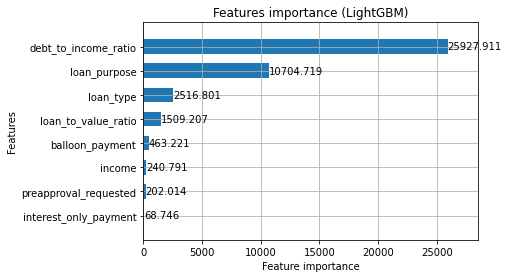

                   FPR       FNR
ethnicity                       
Hispanic      0.312842  0.158954
Non-Hispanic  0.261194  0.091463

                               Unmitigated
Overall selection rate            0.702074
Demographic parity difference     0.021882
Demographic parity ratio          0.969641
------                                    
Overall balanced error rate       0.772877
Balanced error rate difference    0.059569
 ------                                   
True positive rate                0.850604
False positive rate difference    0.051648
False negative rate difference     0.06749
Equalized odds difference          0.06749
  ------                                  
Overall AUC                       0.833503
AUC difference                    0.048587


In [54]:
get_fairness_unaware_model(df_train, df_test, Y_train, Y_test, C_train, C_test, C_str_train, C_str_test)

In [55]:
unmitigated_FL_ethinicity = unmitigated_model
print(unmitigated_FL_ethinicity)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')


In [56]:
fl_ethnicity_test_scores = unmitigated_FL_age.predict_proba(df_test)[:, 1]
fl_ethnicity_test_preds = (fl_ethnicity_test_scores >= np.mean(Y_train)) * 1
fl_ethnicity_test_preds = pd.DataFrame(fl_ethnicity_test_preds)
C_str_test.reset_index(drop= True, inplace= True)
unmigigated_pred_mid_ethnicity = pd.concat([fl_ethnicity_test_preds , C_str_test], axis="columns")
unmigigated_pred_mid_ethnicity

,0,ethnicity
0,1,Hispanic
1,0,Hispanic
2,1,Hispanic
3,0,Non-Hispanic
4,1,Hispanic
...,...,...
3177,1,Non-Hispanic
3178,1,Hispanic
3179,0,Hispanic
3180,1,Hispanic


In [57]:
unmigigated_pred_mid_race.to_excel(r'fl_unmitigated_pred_ethnicity.xlsx', index=False)

## Mitigating Equalized Odds Difference with Postprocessing
We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [58]:
df_train_balanced_ethnicity_FL, Y_train_balanced_ethnicity_FL, A_train_balanced_ethinicity_FL = get_thresholdOptimizer_model(unmitigated_FL_ethinicity, test_preds, test_scores, C_train, C_test, C_str_test)
print()
ThresholdOptimizer_FL_ethinicity = TO
print(ThresholdOptimizer_FL_ethinicity)

                               Unmitigated ThresholdOptimizer
Overall selection rate            0.702074           0.863922
Demographic parity difference     0.021882           0.028188
Demographic parity ratio          0.969641           0.967526
------                                                       
Overall balanced error rate       0.772877           0.705578
Balanced error rate difference    0.059569           0.039905
 ------                                                      
True positive rate                0.850604            0.97582
False positive rate difference    0.051648           0.076503
False negative rate difference     0.06749           0.003306
Equalized odds difference          0.06749           0.076503
  ------                                                     
Overall AUC                       0.833503           0.705578
AUC difference                    0.048587           0.039905

ThresholdOptimizer(constraints='equalized_odds',
                   e

The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations


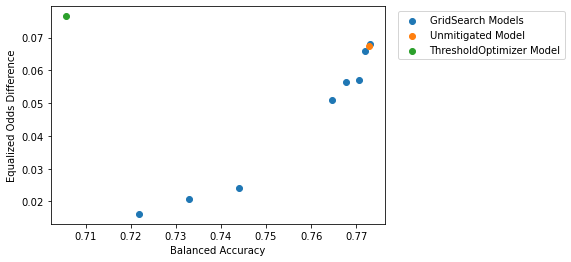

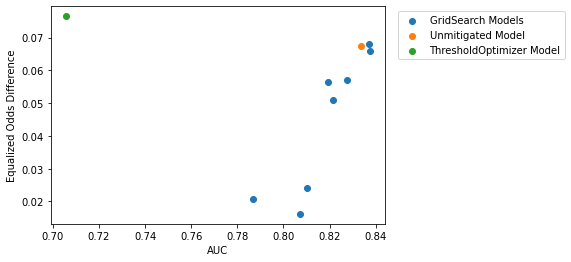

                               Unmitigated ThresholdOptimizer GridSearch_33  \
Overall selection rate            0.702074           0.863922      0.692332   
Demographic parity difference     0.021882           0.028188      0.030025   
Demographic parity ratio          0.969641           0.967526      0.956904   
------                                                                        
Overall balanced error rate       0.772877           0.705578      0.732868   
Balanced error rate difference    0.059569           0.039905      0.000317   
 ------                                                                       
True positive rate                0.850604            0.97582      0.819085   
False positive rate difference    0.051648           0.076503      0.020736   
False negative rate difference     0.06749           0.003306      0.020102   
Equalized odds difference          0.06749           0.076503      0.020736   
  ------                                            

In [59]:
get_gridSearch_model(unmitigated_FL_ethinicity, postprocess_preds, test_scores, test_preds, models_dict, C_str_test, df_train_balanced_ethnicity_FL, Y_train_balanced_ethnicity_FL, A_train_balanced_ethinicity_FL)
print()
GS_ethinicity_FL_models = GS_models
print(GS_ethinicity_FL_models)
print()
GS_ethinicity_FL_metrics = GS_metrics
print(GS_ethinicity_FL_metrics)

In [86]:
# chose the model with AUC = 85.98% from grid search
test_pred_gird_search_168 = GS_ethinicity_FL_metrics.get("GridSearch_168")[0]

In [87]:
test_pred_gird_search_168_series = pd.Series(test_pred_gird_search_168)
test_pred_gird_search_168_series.reset_index(drop=True, inplace=True)

In [88]:
test_pred_gird_search_168_series.sum()

2192

In [89]:
C_str_test.reset_index(drop= True, inplace= True)

In [90]:
test_preds

array([1, 0, 1, ..., 0, 1, 1])

In [91]:
migigated_pred_mid_ethnicity = pd.concat([test_pred_gird_search_168_series , C_str_test], axis="columns")

In [92]:
test_pred_gird_search_168_series

0       1
1       1
2       1
3       0
4       1
       ..
3177    1
3178    1
3179    0
3180    1
3181    1
Length: 3182, dtype: int32

In [93]:
migigated_pred_mid_ethnicity

,0,ethnicity
0,1,Hispanic
1,1,Hispanic
2,1,Hispanic
3,0,Non-Hispanic
4,1,Hispanic
...,...,...
3177,1,Non-Hispanic
3178,1,Hispanic
3179,0,Hispanic
3180,1,Hispanic


In [94]:
migigated_pred_mid_ethnicity.to_excel(r'fl_mitigated_pred_ethnicity.xlsx', index=False)

## Conclusion
In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.